# Capstone 2 Project - Sentiment Analysis from Twitter #IPL   


<img src="https://github.com/sunilayyaps/datascience/blob/master/capstone-project2/ipl/images/social_sentiment_logo.png?raw=true">


In [1]:
# General:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing
import csv
import plotly
# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from textblob import TextBlob
from wordcloud import WordCloud
from credentials import *    # This will allow us to use the keys as variables
from textblob import TextBlob
import re
from wordcloud import STOPWORDS
from plotly import graph_objs
from plotly.offline import init_notebook_mode, iplot
from plotly import __version__
init_notebook_mode()
print("plotly version:",__version__)
from collections import Counter

import os
import nltk
#nltk.download('stopwords')

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


plotly version: 2.4.0


/Users/sunilayyappan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [2]:
# Access:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True)
#####United Airlines
# Open/Create a file to append data
csvFile = open('sscricket.csv', 'a')
#Use csv Writer
csvWriter = csv.writer(csvFile)
for tweet in tweepy.Cursor(api.search,q="#IPL",count=1000,
                           lang="en",
                           since="2018-02-18").items():
    csvWriter.writerow([tweet.id,tweet.created_at, tweet.text,tweet.source,tweet.favorite_count,tweet.retweet_count])

In [3]:
col_Names = ["id","created", "tweet","source","fav_count","retweet"]
data_tweet = pd.read_csv('sscricket.csv', names=col_Names)


# We display the first 10 elements of the dataframe:
display(data_tweet.head(5))

,id,created,tweet,source,fav_count,retweet
0,965350193221730305,2018-02-18 22:19:56,playing cricket is not a job..break the #Prote...,Twitter for Android,0,0
1,965349173636882432,2018-02-18 22:15:52,There has been a recent update to the Kama Sut...,Twitter for Android,0,0
2,965334489001013249,2018-02-18 21:17:31,"If I was a SA cricketer right now, I'd never w...",Twitter for Android,0,0
3,965326993255432192,2018-02-18 20:47:44,@BhuviOfficial Congratulations. The only India...,Twitter for Android,0,0
4,965303365193187328,2018-02-18 19:13:51,RT @PratVikash: Markaram's catch on Pink Day O...,Twitter Web Client,0,1


In [4]:
data_tweet.shape

(12376, 6)

In [5]:
data_tweet['len']  = data_tweet['tweet'].apply(len)
display(data_tweet.head(5))

,id,created,tweet,source,fav_count,retweet,len
0,965350193221730305,2018-02-18 22:19:56,playing cricket is not a job..break the #Prote...,Twitter for Android,0,0,139
1,965349173636882432,2018-02-18 22:15:52,There has been a recent update to the Kama Sut...,Twitter for Android,0,0,112
2,965334489001013249,2018-02-18 21:17:31,"If I was a SA cricketer right now, I'd never w...",Twitter for Android,0,0,137
3,965326993255432192,2018-02-18 20:47:44,@BhuviOfficial Congratulations. The only India...,Twitter for Android,0,0,126
4,965303365193187328,2018-02-18 19:13:51,RT @PratVikash: Markaram's catch on Pink Day O...,Twitter Web Client,0,1,134


In [6]:
# We extract the mean of lenghts:
mean = np.mean(data_tweet['len'])
print("The length's average in tweets: {}".format(mean))

The length's average in tweets: 117.4580639948287


In [7]:
# We extract the tweet with more FAVs and more RTs:

fav_max = np.max(data_tweet['fav_count'])
rt_max  = np.max(data_tweet['retweet'])

fav = data_tweet[data_tweet.fav_count == fav_max].index[0]
rt  = data_tweet[data_tweet.retweet == rt_max].index[0]

# Max FAVs:
print("The tweet with more likes is: \n{}".format(data_tweet['tweet'][fav]))
print("Number of likes: {}".format(fav_max))
print("{} characters.\n".format(data_tweet['len'][fav]))

# Max RTs:
print("The tweet with more retweets is: \n{}".format(data_tweet['tweet'][rt]))
print("Number of retweets: {}".format(rt_max))
print("{} characters.\n".format(data_tweet['len'][rt]))

The tweet with more likes is: 
#KXIP and #MI must be worried about Miller and Duminy’s form...nowhere close to their best in 2018. #IPL
Number of likes: 2960
104 characters.

The tweet with more retweets is: 
RT @IPLCricket: Most Fan Based Team In #IPL

Favorite : #MI

Retweet : #CSK

Reply : #RCB

#IPLAuction #IPL2018
Number of retweets: 4095
111 characters.



In [8]:
# We create time series for data:

tlen = pd.Series(data=data_tweet['len'].values, index=data_tweet['created'])
tfav = pd.Series(data=data_tweet['fav_count'].values, index=data_tweet['created'])
tret = pd.Series(data=data_tweet['retweet'].values, index=data_tweet['created'])

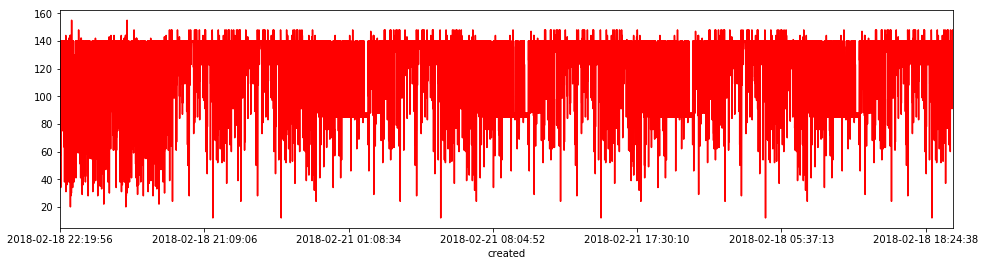

In [9]:
# Lenghts along time:
tlen.plot(figsize=(16,4), color='r');

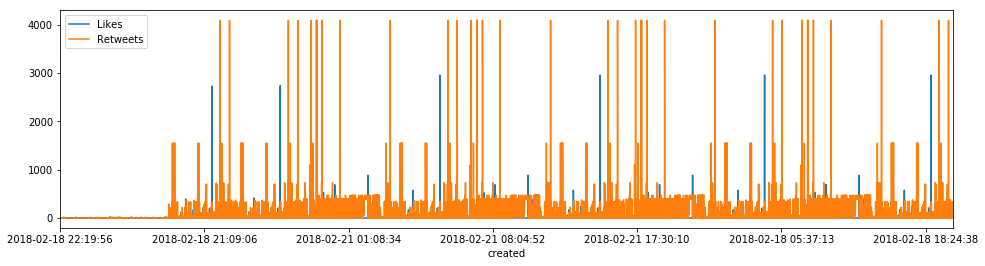

In [10]:
# Likes vs retweets visualization:
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);

In [11]:
# We obtain all possible sources:
sources = []
for source in data_tweet['source']:
    if source not in sources:
        sources.append(source)

# We print sources list:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* Twitter for Android
* Twitter Web Client
* Twitter Lite
* Twitter for iPhone
* Mobile Web (M2)
* Twitter for BlackBerry®
* Twitter for iPad
* Twitter for Windows
* Twitter for BlackBerry
* Twitter for Windows Phone
* TweetCaster for Android
* TweetDeck
* Flamingo for Android
* Fenix 2
* Sprout Social
* Paper.li
* IFTTT
* Facebook
* Hootsuite
* Crystal Clear DM SPC
* Media Studio
* Cloudhopper
* LaterMedia
* dlvr.it
* Instagram
* The Gujarat Lions FC
* Rising Pune SuperGiants FC
* WarnieBolt_ebx
* CricText
* Ripl App
* DragPlus
* Postcron App
* MyCricketBot Demo
* Tweet.Diary
* IPLClub
* Social Reputation
* News24online
* nkjknjn
* Tweetbot for iΟS
* Make a Tweet
* FalconPro3
* Dhoni Fans 7


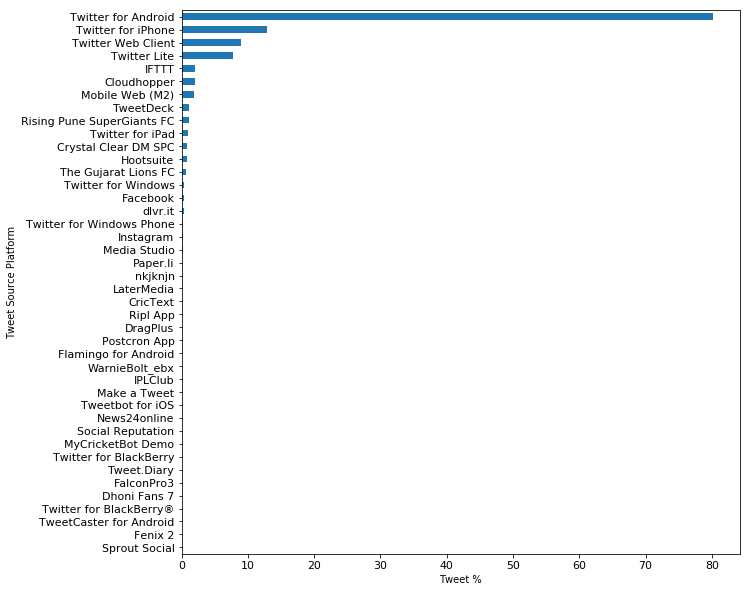

In [12]:
# We create a numpy vector mapped to labels:
percent = np.zeros(len(sources))

for source in data_tweet['source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

data = pd.Series(percent, index=sources, name='sources')
data.sort_values(ascending=True, inplace=True)
data.plot.barh(fontsize=11, figsize=(10, 10));
_ = plt.xlabel('Tweet %')
_ = plt.ylabel('Tweet Source Platform')

In [14]:
def count_by_lambda(expression, word_array):
            return len(list(filter(expression, word_array)))
    
def count_occurences(character, word_array):
            counter = 0
            for j, word in enumerate(word_array):
                for char in word:
                    if char == character:
                        counter += 1
            return counter

In [15]:
data_tweet['uppercase_no'] = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),data_tweet['tweet']))
data_tweet['hashtag_no'] = list(map(lambda txt: count_occurences('#', txt),data_tweet['tweet']))
data_tweet['exclamation_no'] = list(map(lambda txt: count_occurences('!', txt),data_tweet['tweet']))
data_tweet['question_no'] = list(map(lambda txt: count_occurences('?', txt),data_tweet['tweet']))
data_tweet['mention_no'] = list(map(lambda txt: count_occurences('@', txt),data_tweet['tweet']))

In [16]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [17]:
# We create a column with the result of the analysis:
data_tweet['SA'] = np.array([ analize_sentiment(tweet) for tweet in data_tweet['tweet'] ])

# We display the updated dataframe with the new column:
display(data_tweet.head(5))

,id,created,tweet,source,fav_count,retweet,len,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,SA
0,965350193221730305,2018-02-18 22:19:56,playing cricket is not a job..break the #Prote...,Twitter for Android,0,0,139,51,1,0,1,4,0
1,965349173636882432,2018-02-18 22:15:52,There has been a recent update to the Kama Sut...,Twitter for Android,0,0,112,32,1,0,0,0,-1
2,965334489001013249,2018-02-18 21:17:31,"If I was a SA cricketer right now, I'd never w...",Twitter for Android,0,0,137,71,1,2,0,1,-1
3,965326993255432192,2018-02-18 20:47:44,@BhuviOfficial Congratulations. The only India...,Twitter for Android,0,0,126,40,2,2,0,1,1
4,965303365193187328,2018-02-18 19:13:51,RT @PratVikash: Markaram's catch on Pink Day O...,Twitter Web Client,0,1,134,38,1,2,0,1,1


In [18]:
# We construct lists with classified tweets:

pos_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] < 0]

In [19]:
# We print percentages:

pos_tweet_count = len(pos_tweets)*100/len(data_tweet['tweet'])
neu_tweet_count = len(neu_tweets)*100/len(data_tweet['tweet'])
neg_tweet_count = len(neg_tweets)*100/len(data_tweet['tweet'])
                                    
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(data_tweet['tweet'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(data_tweet['tweet'])))
print("Percentage for negative tweets: {}%".format(len(neg_tweets)*100/len(data_tweet['tweet'])))


Percentage of positive tweets: 44.67517776341306%
Percentage of neutral tweets: 45.88720103425986%
Percentage for negative tweets: 9.437621202327085%


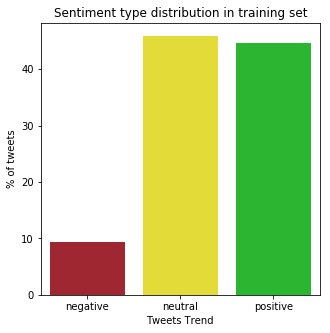

In [20]:
colors = ['#B21321','#FFF61B','#14CC1C']
x_bar=["negative","neutral","positive"]
y_bar=[neg_tweet_count, neu_tweet_count, pos_tweet_count]
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax = sns.barplot(x=x_bar, y=y_bar,palette=colors);
ax.set(ylabel='% of tweets', xlabel='Tweets Trend')
title = 'Sentiment type distribution in training set'
plt.title(title,fontsize = 12)
plt.show()

In [21]:
# Deleting stopwords and punctuation is key for proper bigram creation
# Deleting stopwords and punctuation is key for proper bigram creation

all_words3 = ', '.join(data_tweet.tweet)
def bigram(text):
    count = 0
    text_bigram = ''
    for letter in text:
        if letter != ' ':
            text_bigram += letter
        else:
            count += 1
            if count % 2 == 0:
                text_bigram += 'x'
            else:
                text_bigram += letter
    return text_bigram

stopwords1 = ['https', 'RT', 'http', '.co','SSCricket']
for stopword in stopwords1:
    all_words3 = all_words3.replace(stopword,'')

words_bigram = bigram(all_words3)

responsibilities_bigram = bigram(all_words3)

Single Cloud:


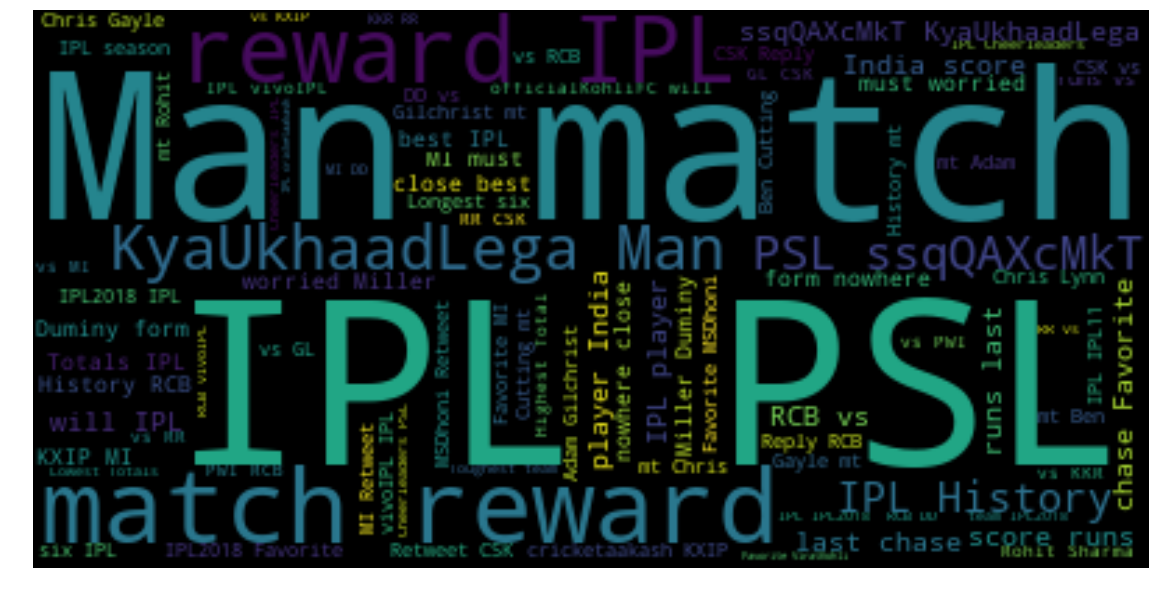

Bigrams:


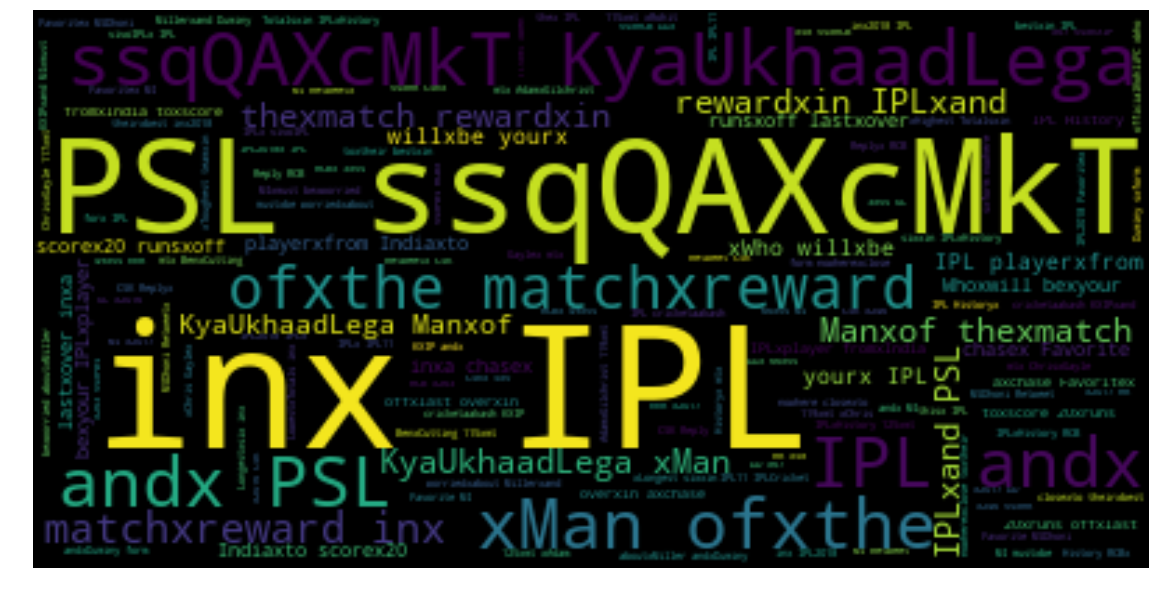

In [22]:
# Single Cloud
wordcloud = WordCloud().generate(all_words3)
print('Single Cloud:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

# Bigram Cloud
wordcloud_bigrams = WordCloud().generate(responsibilities_bigram)
print('Bigrams:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis("off")
plt.show();

In [23]:
import os
import pandas as pd
import numpy as np
from IPython.display import display

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Load Labeled Training Data 

For Bag-of-words approach, we're going to use labeled training data for supervised learning. Read the labeled training data in .tsv file with pandas.read_csv.

In [24]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('sscricket.xls', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
data_tweet.to_excel(writer, sheet_name='Sheet1')
# Close the Pandas Excel writer and output the Excel file.
writer.save()


In [25]:
df_train = pd.read_excel('ipltweets.xls', header=0, delimiter="\t", quoting=3)

<div class="span25 alert alert-warning">
Here, header=0 indicates the first line of the tsv file contains the column names, delimiter="\t" means the file uses tap as delimiter, and quoting=3 tells Python to ignore double quotes.

Take a look at the training data.
</div>

In [26]:
print('Dimension of Labeled Training Data: {}.'.format(df_train.shape))
print('There are {0} samples and {1} variables in the training data.'.format(df_train.shape[0], df_train.shape[1]))

Dimension of Labeled Training Data: (435, 8).
There are 435 samples and 8 variables in the training data.


In [27]:
display(df_train.head())

,id,created,tweet,source,fav_count,retweet,len,SA
0,965356476700094464,2018-02-18 22:44:54,RT @Beingsukhveer: Most Fan Based Team in #ICC...,Twitter Lite,0,5,140,1
1,965354854284701696,2018-02-18 22:38:27,RT @cricketaakash: #KXIP and #MI must be worri...,Twitter Lite,0,49,123,1
2,965354139499749376,2018-02-18 22:35:36,RT @Aparajithan29: #chrisgayle situation in to...,Twitter for Android,0,1,97,0
3,965341599533236224,2018-02-18 21:45:47,RT @cricketaakash: #KXIP and #MI must be worri...,Twitter for Android,0,49,123,1
4,965335164787113984,2018-02-18 21:20:13,"RT @cricketaakash: As you'd asked, here's the ...",Twitter Lite,0,161,137,0


<div class="span25 alert alert-info">
Take a closer look at a tweet entry.
</div>

In [28]:
print(df_train.tweet[0])

RT @Beingsukhveer: Most Fan Based Team in #ICC 

Favorite :- Pakistan

Retweet :- India 

reply :-  Others

#IPL #IPL2018 #Raina #Bhuvi #Dh…


<div class="span25 alert alert-info">
Even though the review text is not in HTML, let's use the package BeautifulSoup. This is a tw
</div>

In [29]:
df_train['review_bs'] = df_train['tweet'].apply(lambda x: BeautifulSoup(x, 'html.parser'))

In [30]:
df_train.review_bs[0].get_text()

'RT @Beingsukhveer: Most Fan Based Team in #ICC \n\nFavorite :- Pakistan\n\nRetweet :- India \n\nreply :-  Others\n\n#IPL #IPL2018 #Raina #Bhuvi #Dh…'

### Data Cleaning and Text Preprocessing


<div class="span25 alert alert-info">
Use re package to remove digits and punctuations. To build a simplified Bag-of-words model, we remove both digits and punctuations.
</div>

In [31]:
df_train['review_letters_only'] = df_train['review_bs'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x.get_text()))

<div class="span25 alert alert-info">
The reviews are now strings of letters only.
</div>

In [32]:
df_train['review_letters_only'][0]

'RT  Beingsukhveer  Most Fan Based Team in  ICC   Favorite    Pakistan  Retweet    India   reply     Others   IPL  IPL      Raina  Bhuvi  Dh '

<div class="span25 alert alert-info">
Convert words into lower case and tonkenize, i.e. split the text into individual words.
</div>

In [33]:
df_train['review_words'] = df_train['review_letters_only'].apply(lambda x: x.lower().split())

<div class="span25 alert alert-info">
The reviews are now list of word strings.
</div>

In [34]:
df_train['review_words'][0]

['rt',
 'beingsukhveer',
 'most',
 'fan',
 'based',
 'team',
 'in',
 'icc',
 'favorite',
 'pakistan',
 'retweet',
 'india',
 'reply',
 'others',
 'ipl',
 'ipl',
 'raina',
 'bhuvi',
 'dh']

<div class="span25 alert alert-info">
Remove stop words with ntlk.
</div>

In [35]:
set_of_stopwords = set(stopwords.words("english"))
df_train['review_meaningful_words'] = df_train['review_words'].apply(lambda x: [w for w in x if not w in set_of_stopwords])

In [36]:
num_removed = len(df_train['review_words'][0]) - len(df_train['review_meaningful_words'][0])
print('For the first review entry, the number of stop words removed is {0}.'.format(num_removed))


For the first review entry, the number of stop words removed is 2.


<div class="span25 alert alert-info">
As the final step, we join the list of words into a single string.
</div>

In [37]:
# train['review_cleaned'] = train['review_stemmed'].apply(lambda x: ' '.join(x)) # uncomment if using stemming
df_train['review_cleaned'] = df_train['review_meaningful_words'].apply(lambda x: ' '.join(x)) # comment if using stemming

<div class="span25 alert alert-info">
Add review_cleaned as a new column to the training data.
</div>



In [38]:
df_train.drop(['tweet', 'review_bs', 'review_letters_only', 'review_words', 'review_meaningful_words'], 
           axis=1, inplace=True)
display(df_train.head())

,id,created,source,fav_count,retweet,len,SA,review_cleaned
0,965356476700094464,2018-02-18 22:44:54,Twitter Lite,0,5,140,1,rt beingsukhveer fan based team icc favorite p...
1,965354854284701696,2018-02-18 22:38:27,Twitter Lite,0,49,123,1,rt cricketaakash kxip mi must worried miller d...
2,965354139499749376,2018-02-18 22:35:36,Twitter for Android,0,1,97,0,rt aparajithan chrisgayle situation today ipl ...
3,965341599533236224,2018-02-18 21:45:47,Twitter for Android,0,49,123,1,rt cricketaakash kxip mi must worried miller d...
4,965335164787113984,2018-02-18 21:20:13,Twitter Lite,0,161,137,0,rt cricketaakash asked playing xi csk aakashva...


In [39]:
print(df_train['review_cleaned'][0])

rt beingsukhveer fan based team icc favorite pakistan retweet india reply others ipl ipl raina bhuvi dh


In [40]:
# Deleting stopwords and punctuation is key for proper bigram creation
# Deleting stopwords and punctuation is key for proper bigram creation
clean_tweets = ', '.join(df_train.review_cleaned)
def bigram(text):
    count = 0
    text_bigram = ''
    for letter in text:
        if letter != ' ':
            text_bigram += letter
        else:
            count += 1
            if count % 2 == 0:
                text_bigram += 'x'
            else:
                text_bigram += letter
    return text_bigram

responsibilities_bigram = bigram(clean_tweets)
clean_tweet = clean_tweets.replace('IPL',' ')


Single Cloud:


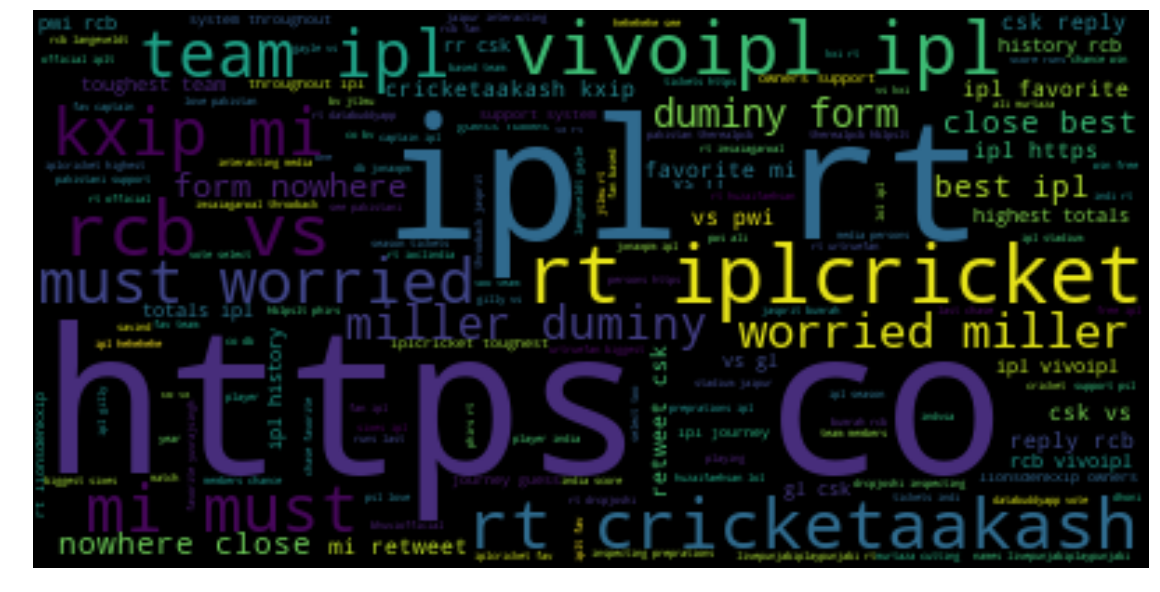

Bigrams:


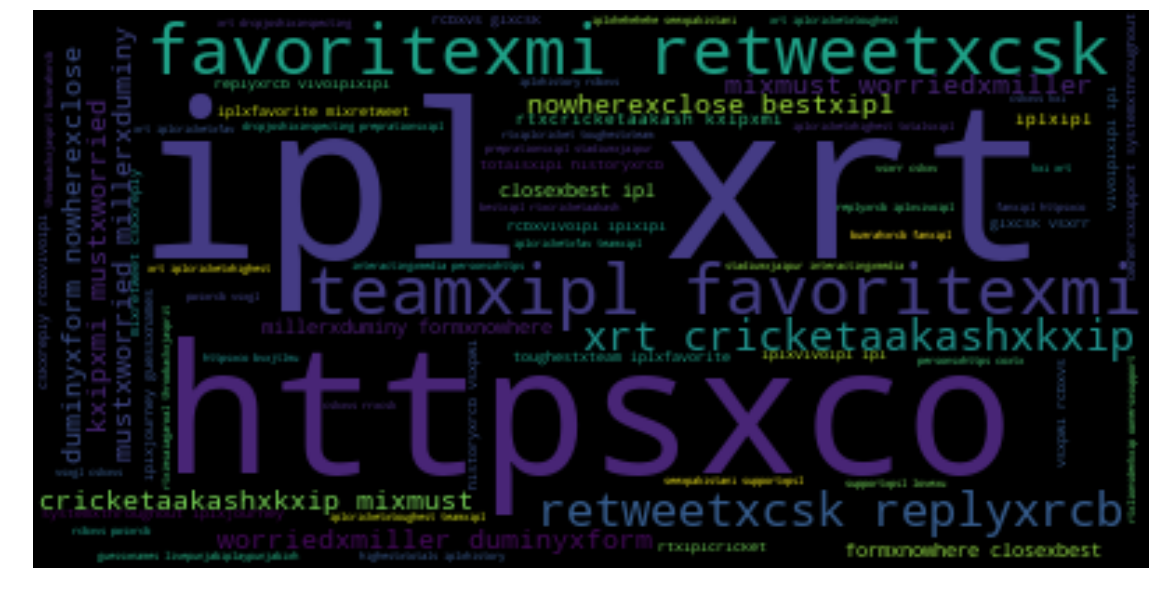

In [41]:
# Single Cloud
wordcloud = WordCloud().generate(clean_tweet)
print('Single Cloud:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

# Bigram Cloud
wordcloud_bigrams = WordCloud().generate(responsibilities_bigram)
print('Bigrams:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis("off")
plt.show();

<div class="span25 alert alert-info">
Now the training data is ready for using Bag of Words.
</div>


## Creating Features from a Bag of Words (Using scikit-learn)¶


In [42]:
vectorizer = CountVectorizer(analyzer="word", preprocessor=None, tokenizer=None, stop_words=None, max_features=5000)

<div class="span25 alert alert-info">
Initialize the CountVectorizer object, which is scikit-learn's bag of words tool. CountVectorizer converts a collection of text documents to a matrix of token counts.
</div>

In [43]:
#train_data_features = vectorizer.fit_transform(list(train['review_cleaned'].values))

# Numpy arrays are easy to work with, so convert the result to an array
#train_data_features = train_data_features.toarray()

data_features = list(df_train['review_cleaned'].values)
data_target = list(df_train['SA'].values)

F_train, F_test, T_train, T_test = train_test_split(data_features, data_target, test_size = 0.3, random_state=42)

In [44]:
messages_bow = vectorizer.fit_transform(F_train)
test_bow = vectorizer.transform(F_test)

print ('Shape of Sparse Matrix: ', messages_bow.shape)
print ('Amount of Non-Zero occurences: ', messages_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * messages_bow.nnz /
                             (messages_bow.shape[0] * messages_bow.shape[1])))
print(messages_bow.shape)
print(test_bow.shape)


Shape of Sparse Matrix:  (304, 894)
Amount of Non-Zero occurences:  3777
sparsity: 1.39%
(304, 894)
(131, 894)


## From occurrences to frequencies

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.fit_transform(messages_bow)
print(messages_tfidf.shape)

tfidf_transformer1 = TfidfTransformer().fit(test_bow)
test_tfidf = tfidf_transformer1.fit_transform(test_bow)
print(test_tfidf.shape)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(messages_tfidf, T_train)

predicted = clf.predict(test_tfidf)

print(np.mean(predicted == T_test))

(304, 894)
(131, 894)
0.778625954198


## Random Forest Classifier

In [47]:
# Initialize a Random Forest classifier with 100 trees
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=42) 

# Fit the forest to the training set, using the bag of words as features and the sentiment labels as labels
# This may take a few minutes to run
rf_clf.fit(messages_tfidf, T_train)
result = rf_clf.predict(test_tfidf)

print(np.mean(result == T_test))

0.847328244275


## Confusion Matrix

In [48]:
print("confusion matrix: ",confusion_matrix(T_test, result))
print("classification report: ", classification_report(T_test, result))

confusion matrix:  [[ 2  8  2]
 [ 0 47  2]
 [ 0  8 62]]
classification report:               precision    recall  f1-score   support

         -1       1.00      0.17      0.29        12
          0       0.75      0.96      0.84        49
          1       0.94      0.89      0.91        70

avg / total       0.87      0.85      0.83       131



## Create a Vocubulary

In [49]:
vocab = vectorizer.get_feature_names()
print(vocab)

['aakashvani', 'aaki', 'abdevilliers', 'absolute', 'according', 'acne', 'acnetreatments', 'actions', 'afghanistan', 'afgvzim', 'agree', 'ah', 'ahmed', 'aimed', 'al', 'alaa', 'ali', 'alj', 'allowed', 'alongside', 'always', 'amazed', 'amazing', 'anitagingskincare', 'another', 'aofnnlvu', 'aparajithan', 'apple', 'appreciate', 'april', 'apvz', 'arindam', 'asked', 'askviru', 'auction', 'available', 'away', 'ayni', 'babies', 'back', 'backtheblackcaps', 'badly', 'baithe', 'ball', 'balls', 'banks', 'banter', 'banvsl', 'bargain', 'based', 'bats', 'batting', 'bbcfl', 'bcci', 'beautiful', 'beauty', 'behind', 'beingsukhveer', 'benefits', 'best', 'bhogleharsha', 'bhuvi', 'bhuviofficial', 'bhuvneshwar', 'big', 'biggest', 'blackcaps', 'bludgeoned', 'board', 'booking', 'books', 'boss', 'bought', 'bowl', 'bowled', 'bowlers', 'boys', 'bpl', 'bpy', 'br', 'bring', 'brings', 'brought', 'bsdg', 'budget', 'bumrah', 'buys', 'bv', 'bzmw', 'call', 'called', 'canada', 'cant', 'captain', 'captaincy', 'captains', 

In [50]:
def clean_reviews(reviews, remove_stopwords=False, stem=False):
    """
    to clean review strings
    review: a list of review strings
    remove_stop_words: whether to remove stop words
    output: a list of clean reviews
    """
    # 1. Remove HTML
    reviews_text = list(map(lambda x: BeautifulSoup(x, 'html.parser').get_text(), reviews))
    #
    # 2. Remove non-letters
    reviews_text = list(map(lambda x: re.sub("[^a-zA-Z]"," ", x), reviews_text))
    #
    # 3. Convert words to lower case and split them
    words = list(map(lambda x: x.lower().split(), reviews_text))
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        set_of_stopwords = set(stopwords.words("english"))
        meaningful_words = list(map(lambda x: [w for w in x if not w in set_of_stopwords], words))
    
    # 5. Optionally stem the words
    if stem:
        porter_stemmer = PorterStemmer()
        wordnet_lemmatizer = WordNetLemmatizer()
        stemmed_words = list(map(lambda x: [porter_stemmer.stem(w) for w in x], meaningful_words))
        stemmed_words = list(map(lambda x:[wordnet_lemmatizer.lemmatize(w) for w in x], stemmed_words))
    
        # 6. Join the words to a single string
        clean_review = map(lambda x: ' '.join(x), stemmed_words)
    else:
        clean_review = list(map(lambda x: ' '.join(x), meaningful_words))
    
    return clean_review

In [51]:
# Read the test data
test = pd.read_excel('ipltweets.xls', header=0, delimiter="\t", quoting=3)

# Verify that there are 25,000 rows and 2 columns
print('The dimension of test data is {}.'.format(test.shape))

# Get a bag of words for the test set, and convert to a numpy array
clean_test_reviews = clean_reviews(list(test['tweet'].values), remove_stopwords=True)
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

The dimension of test data is (435, 8).


In [52]:
test.head()

,id,created,tweet,source,fav_count,retweet,len,SA
0,965356476700094464,2018-02-18 22:44:54,RT @Beingsukhveer: Most Fan Based Team in #ICC...,Twitter Lite,0,5,140,1
1,965354854284701696,2018-02-18 22:38:27,RT @cricketaakash: #KXIP and #MI must be worri...,Twitter Lite,0,49,123,1
2,965354139499749376,2018-02-18 22:35:36,RT @Aparajithan29: #chrisgayle situation in to...,Twitter for Android,0,1,97,0
3,965341599533236224,2018-02-18 21:45:47,RT @cricketaakash: #KXIP and #MI must be worri...,Twitter for Android,0,49,123,1
4,965335164787113984,2018-02-18 21:20:13,"RT @cricketaakash: As you'd asked, here's the ...",Twitter Lite,0,161,137,0


## Random Forest
Let's try a random forest with the features we just created.

In [53]:
messages_bow = vectorizer.fit_transform(F_train)
test_bow = vectorizer.transform(F_test)

print ('Shape of Sparse Matrix: ', messages_bow.shape)
print ('Amount of Non-Zero occurences: ', messages_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * messages_bow.nnz /
                             (messages_bow.shape[0] * messages_bow.shape[1])))
print(messages_bow.shape)
print(test_bow.shape)

Shape of Sparse Matrix:  (304, 894)
Amount of Non-Zero occurences:  3777
sparsity: 1.39%
(304, 894)
(131, 894)
